In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import torch
import prophet
from prophet.plot import plot_plotly, plot_components_plotly
import pmdarima as pmd
import statsmodels 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from ThymeBoost import ThymeBoost as tb
import sklearn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width : 98% !important; }</style>"))

pd.set_option('display.max_columns',500)

Importing plotly failed. Interactive plots will not work.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
plt.rcParams["figure.figsize"] = (24,16)

In [3]:
## In this notebook I am just going to be using some pretty standard time series sample datasets, showing the correct ways to fit models and ultimately predict
## with those models. I also want to plot each model and its components (when applicable) and compare all models' forecasts to one another

alcohol = pd.read_csv('/Users/APinkerton/Downloads/archive (18)/Alcohol_Sales.csv')
liquor = pd.read_csv('/Users/APinkerton/Downloads/archive (18)/BeerWineLiquor.csv')
energy = pd.read_csv('/Users/APinkerton/Downloads/archive (18)/energydata_complete.csv')
miles = pd.read_csv('/Users/APinkerton/Downloads/archive (18)/Miles_Traveled.csv')

<AxesSubplot:>

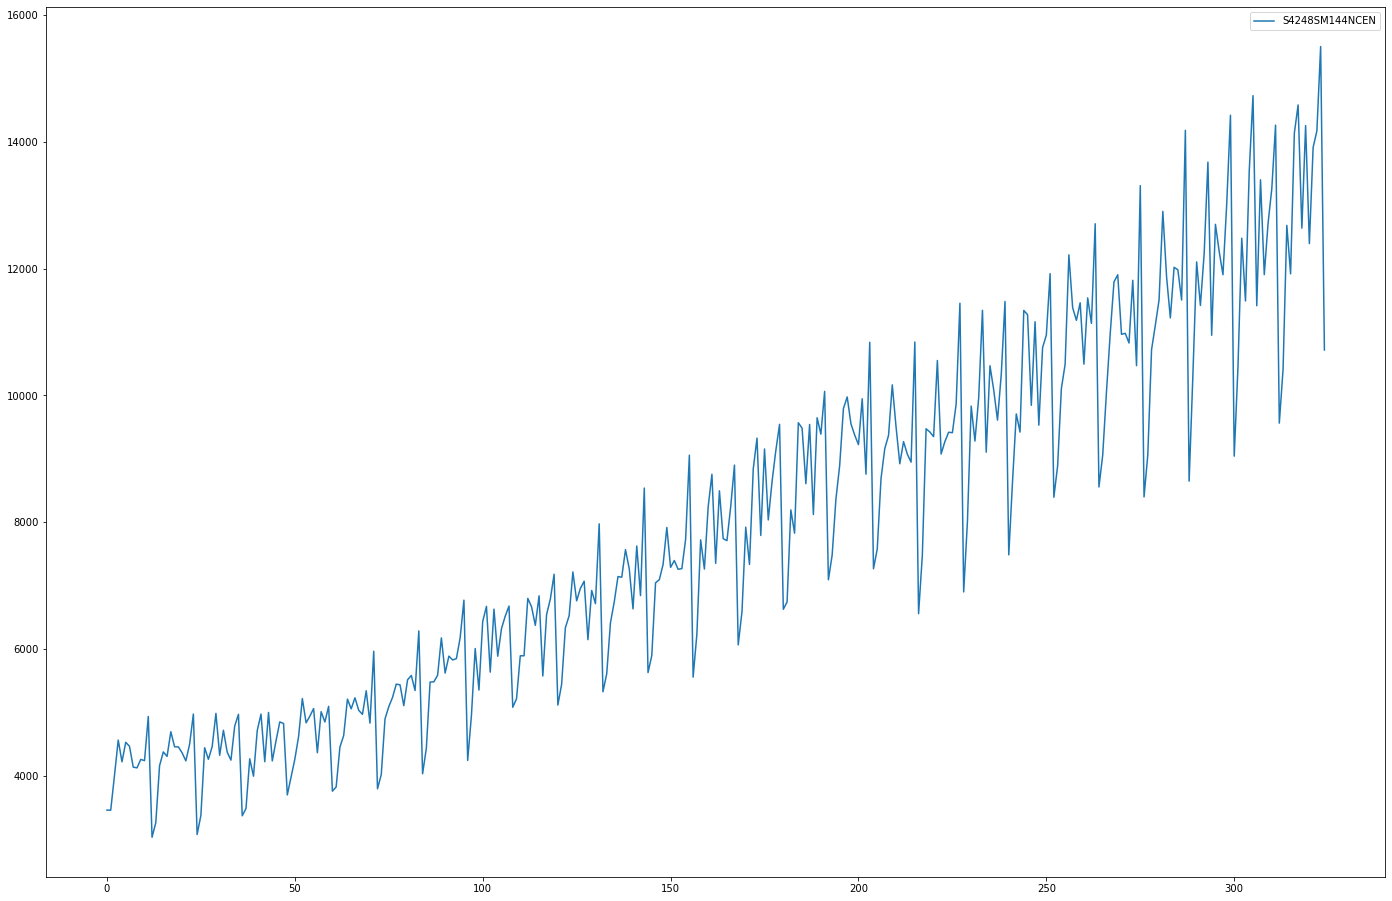

In [4]:
# liquor.plot()
# energy.plot()
# miles.plot()

# Looking at the alcohol monthly volume dataset, which I will use as an example for all of my models

alcohol.plot()

In [5]:
## Splitting the dataset into training (until the final 24 values), and testing (last 24 values). Also, renaming columns to a pretty standard 'ds' and 'y'
alcohol.columns = ['ds','y']
alcohol['ds']=pd.to_datetime(alcohol['ds'])
train_alc = alcohol[:-24]
test_alc = alcohol[-24:]

test_alc

,ds,y
301,2017-02-01,10452
302,2017-03-01,12481
303,2017-04-01,11491
304,2017-05-01,13545
305,2017-06-01,14730
306,2017-07-01,11416
307,2017-08-01,13402
308,2017-09-01,11907
309,2017-10-01,12711
310,2017-11-01,13261


## ETS Model

In [6]:
## First model is a pretty basic Error, Trend, Seasonality model (Seasonality of the alcohol dataset being 12). I noted that in the lineplot of the data, the seasonal
## trends of the target variable do not seem to 'multiply' to multiple times the lowest monthly volumes, so I am noting an additive parameter for all the E,T, and S

ets_model = ETSModel(
    np.asarray(train_alc['y'].astype('float64')),
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=12,
)
fit = ets_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  8.47071D+00    |proj g|=  9.88789D-01

At iterate    1    f=  7.71081D+00    |proj g|=  9.99800D-01

At iterate    2    f=  7.53717D+00    |proj g|=  3.32339D-01

At iterate    3    f=  7.51595D+00    |proj g|=  9.47055D-01

At iterate    4    f=  7.49996D+00    |proj g|=  2.45042D-01

At iterate    5    f=  7.47736D+00    |proj g|=  3.68637D-01

At iterate    6    f=  7.47547D+00    |proj g|=  3.44021D-01

At iterate    7    f=  7.47278D+00    |proj g|=  1.77585D-01

At iterate    8    f=  7.47157D+00    |proj g|=  7.86680D-02

At iterate    9    f=  7.47109D+00    |proj g|=  2.72710D-02

At iterate   10    f=  7.47100D+00    |proj g|=  7.05977D-03

At iterate   11    f=  7.47100D+00    |proj g|=  1.06990D-03

At iterate   12    f=  7.47100D+00    |proj g|=  2.99138D-04

At iterate   13    f=  7.4

In [7]:
## Getting a summary of the ETS model, examining the fitted model's parameters
print(fit.summary())
pars = fit.params
pars

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  301
Model:                      ETS(AAdA)   Log Likelihood               -2248.770
Date:                Sat, 04 Jun 2022   AIC                           4535.540
Time:                        19:43:36   BIC                           4605.975
Sample:                             0   HQIC                          4563.725
                                - 301   Scale                       180613.712
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1054      0.029      3.648      0.000       0.049       0.162
smoothing_trend         0.0071      0.001      9.438      0.000       0.006       0.009
smoothing_season

array([ 1.05367839e-01,  7.06812337e-03,  8.94542698e-01,  9.80000000e-01,
        4.14579456e+03,  4.61520625e+00, -1.64114563e+03, -1.42322906e+03,
       -6.78104132e+02, -6.59187490e+02, -3.10885413e+02, -1.21416687e+02,
       -5.15010356e+02, -3.12479155e+02, -6.24156233e+02, -5.77937510e+02,
       -3.19406368e+02,  0.00000000e+00])

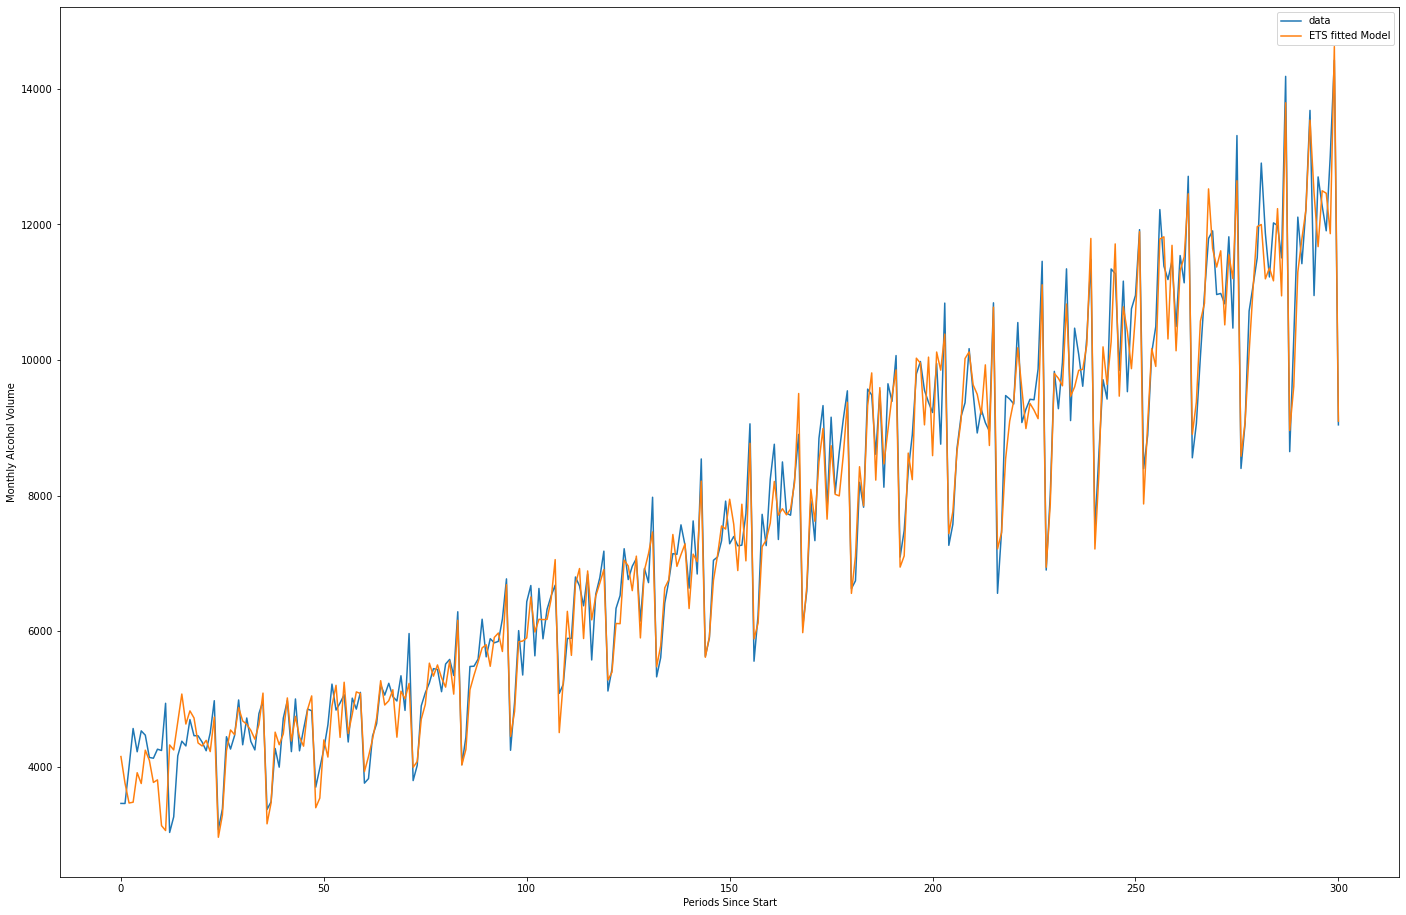

In [8]:
## Now plotting the fitted model (orange line) over the actual data (blue) -- An alright fit, but there is certainly room for improvement

train_alc['y'].plot(label="data")
plt.ylabel("Monthly Alcohol Volume")
plt.xlabel("Periods Since Start")
pd.Series(fit.fittedvalues).plot(label="ETS fitted Model")
plt.legend()

In [9]:
## Using the ETS model for predictions, which we can compare to our test data
preds = fit.predict(start=302, end=325)
preds

array([12384.42167554, 11725.40727006, 12532.97582878, 13952.99213626,
       11372.75505486, 13016.09299069, 12606.52057157, 12294.38499304,
       13284.05953408, 14702.74286265,  9324.31772717, 10964.57537816,
       12654.59456272, 11990.17669949, 12792.44986962, 14207.27669628,
       11621.95392368, 13260.30788214, 12845.85116519, 12528.92897478,
       13513.91263619, 14927.99890272,  9545.06864644, 11180.91127904])

In [10]:
# Just putting the predictions into a dataframe with time labels
pred_ds = pd.date_range(start='2017-02-01',end='2019-01-01',freq='MS')

In [11]:
alcohol
preds_df = pd.concat([pd.Series(list(range(301,325))),pd.Series(pred_ds),pd.Series(preds)],axis=1,ignore_index=True)
preds_df.columns = ['index','ds','forecast']
preds_df.set_index('index',inplace=True)
preds_df

,ds,forecast
index,,
301,2017-02-01,12384.421676
302,2017-03-01,11725.407270
303,2017-04-01,12532.975829
304,2017-05-01,13952.992136
305,2017-06-01,11372.755055
306,2017-07-01,13016.092991
307,2017-08-01,12606.520572
308,2017-09-01,12294.384993
309,2017-10-01,13284.059534


In [12]:
## Looking at the RMSE for the model -- around 2070, which isn't great for values around 12k - 16k
res_df = pd.merge(alcohol,preds_df,left_on='ds',right_on='ds',how='left')
statsmodels.tools.eval_measures.rmse(res_df['y'][-24:],res_df['forecast'][-24:])

2069.8972006870886

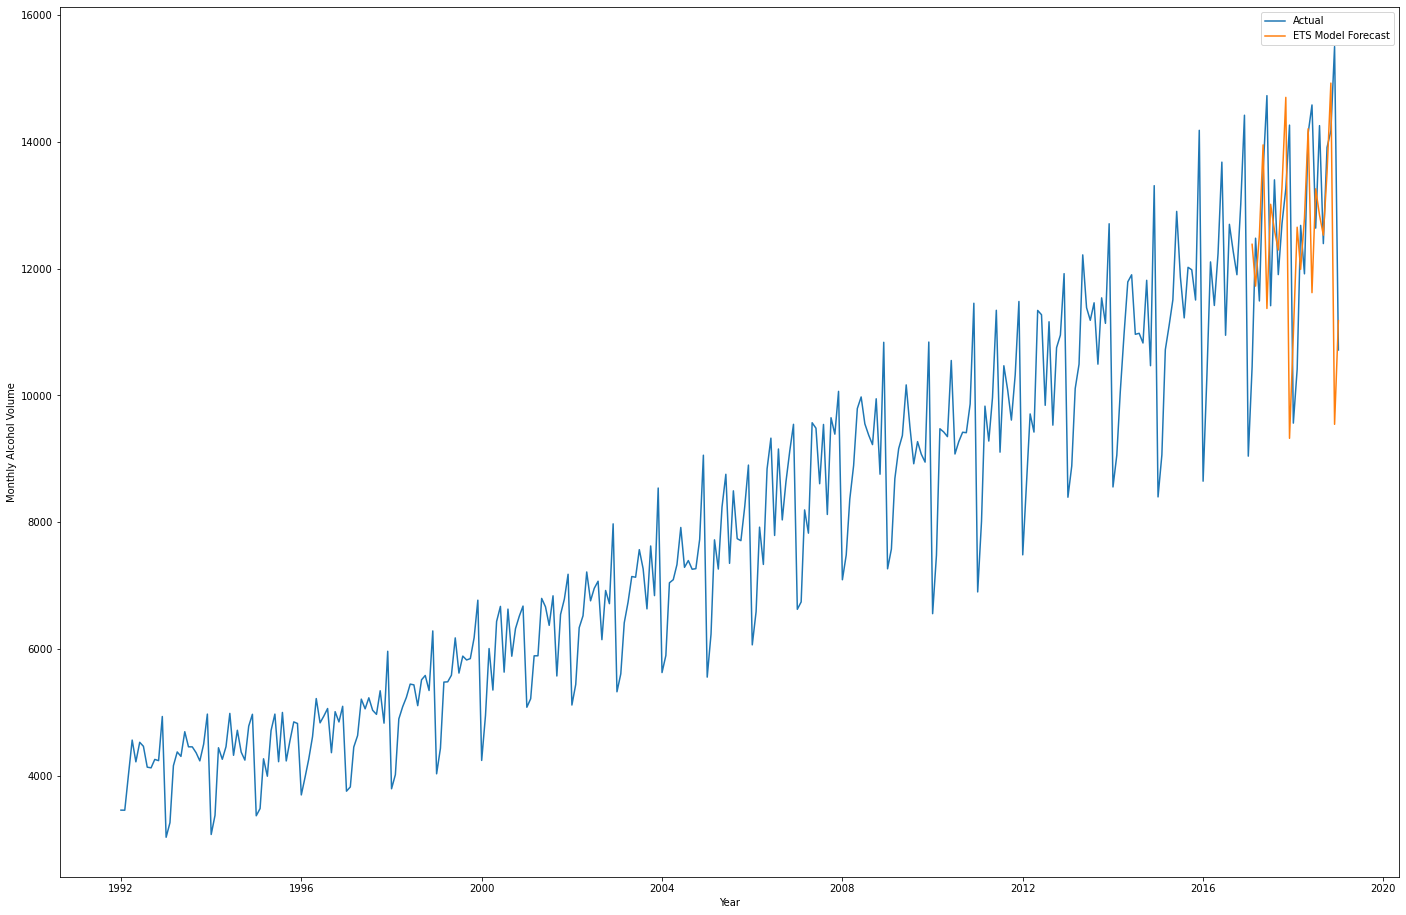

In [13]:
# Plotting the predictions versus actuals

plt.plot(res_df['ds'],res_df['y'],label='Actual')
plt.plot(res_df['ds'],res_df['forecast'],label='ETS Model Forecast')
plt.ylabel('Monthly Alcohol Volume')
plt.xlabel('Year')
plt.legend()
plt.show()

In [14]:
## Creating a Symmettrics Mean Absolute Percent Error function to use on all the models
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [15]:
## SMAPE of 11.86% for ETS
smape_ETS = smape(res_df['y'][-24:],res_df['forecast'][-24:])
print(smape_ETS)

0.11856981444448468


## SARIMA

In [16]:
# creating and fitting an AutoARIMA model with a 12 frequency seasonality

arim = pmd.AutoARIMA(m=12)
arim.fit(train_alc['y'])

AutoARIMA(m=12)

In [17]:
## Printing the AutoArima's fitted best parameters, forecasting out 24 periods
print(arim.get_params())
arim_preds = arim.predict(n_periods=24)

{'D': None, 'alpha': 0.05, 'd': None, 'error_action': 'trace', 'information_criterion': 'aic', 'm': 12, 'max_D': 1, 'max_P': 2, 'max_Q': 2, 'max_d': 2, 'max_order': 5, 'max_p': 5, 'max_q': 5, 'maxiter': 50, 'method': 'lbfgs', 'n_fits': 10, 'n_jobs': 1, 'offset_test_args': None, 'out_of_sample_size': 0, 'random': False, 'random_state': None, 'scoring': 'mse', 'scoring_args': None, 'seasonal': True, 'seasonal_test': 'ocsb', 'seasonal_test_args': None, 'start_P': 1, 'start_Q': 1, 'start_p': 2, 'start_params': None, 'start_q': 2, 'stationary': False, 'stepwise': True, 'suppress_warnings': True, 'test': 'kpss', 'trace': False, 'trend': None, 'with_intercept': 'auto'}


In [18]:
## Putting forecast values alongside the actuals to graph later
arim_df = pd.concat([pd.Series(list(range(301,325))),pd.Series(pred_ds),pd.Series(arim_preds)],axis=1,ignore_index=True)
arim_df.columns = ['index','ds','forecast']
arim_df.set_index('index',inplace=True)
arima_res_df = pd.merge(alcohol,arim_df,left_on='ds',right_on='ds',how='left')
arima_res_df

,ds,y,forecast
0,1992-01-01,3459,NaN
1,1992-02-01,3458,NaN
2,1992-03-01,4002,NaN
3,1992-04-01,4564,NaN
4,1992-05-01,4221,NaN
...,...,...,...
320,2018-09-01,12396,12841.297834
321,2018-10-01,13914,13844.172178
322,2018-11-01,14174,13769.208025
323,2018-12-01,15504,15219.919471


In [19]:
## Smape of the ARIMA model is ~2.5% -- note that real life datasets rarely give such strong SMAPE values, but the nature of time series dataset
# make it particularly suited for an ARIMA model

smape_arima = smape(arima_res_df['y'][-24:],arima_res_df['forecast'][-24:])
print(smape_arima)

0.02540259312823353


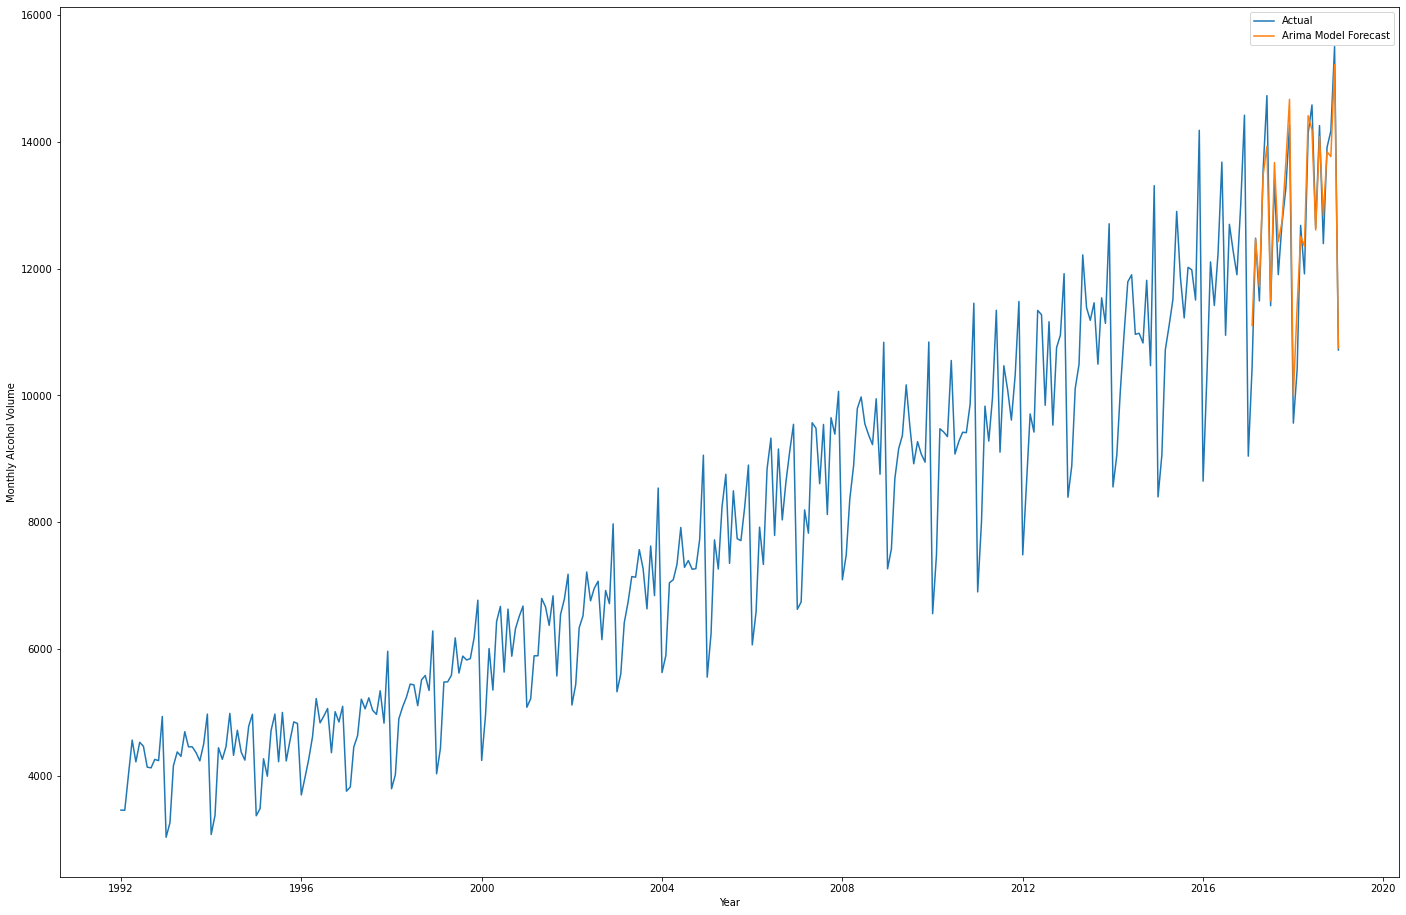

In [20]:
# Plotting ARIMA model's predictions versus historical and actuals

plt.plot(arima_res_df['ds'],arima_res_df['y'],label='Actual')
plt.plot(arima_res_df['ds'],arima_res_df['forecast'],label='Arima Model Forecast')
plt.ylabel('Monthly Alcohol Volume')
plt.xlabel('Year')
plt.legend()
plt.show()

## Prophet

In [21]:
train_alc

,ds,y
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
296,2016-09-01,12272
297,2016-10-01,11905
298,2016-11-01,13016
299,2016-12-01,14421


In [22]:
test_alc['y']

301    10452
302    12481
303    11491
304    13545
305    14730
306    11416
307    13402
308    11907
309    12711
310    13261
311    14265
312     9564
313    10415
314    12683
315    11919
316    14138
317    14583
318    12640
319    14257
320    12396
321    13914
322    14174
323    15504
324    10718
Name: y, dtype: int64

In [23]:
## Grid Searching the best parameters for a prophet model
growths=['linear']
SPS=[5,10,15,20,25,30]
HPS=[5,10,15,20,25]

empt_params =[]
empt_smapes=[]
for G in growths:
    for sps in SPS:
        for h in HPS:
            prop_mdl = prophet.Prophet(growth = G, seasonality_prior_scale = sps,holidays_prior_scale=h ,seasonality_mode='additive',yearly_seasonality=True,
            weekly_seasonality=True,daily_seasonality=False)
            prop_mdl.fit(train_alc)
            future = prop_mdl.make_future_dataframe(periods=24,freq='MS')
            prop_forecast = prop_mdl.predict(future)
            empt_smapes.append(smape(prop_forecast['yhat'],test_alc['y']))
            empt_params.append((G,sps,h))


Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.533   0.000288529       112.335      0.5874      0.5874      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       943.141    0.00480015       99.2074           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       943.203    0.00012446       91.6746   1.127e-06       0.001      346  LS failed, Hessian reset 
     267       943.253    6.7337e-05        90.103    9.95e-07       0.001      442  LS failed, Hessian reset 
     299       943.259   1.79995e-05       66.8326           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       943.264    2.2136e-05        61.565   2.684e-07       0.001      546  LS failed, Hessian reset

Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.495    0.00301934       106.468       0.359       0.359      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       942.867   0.000126781       104.832   1.607e-06       0.001      206  LS failed, Hessian reset 
     173       943.028   0.000210516       69.7294   4.169e-06       0.001      316  LS failed, Hessian reset 
     199       943.092   5.89809e-05       57.0593      0.2258           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       943.105   2.32216e-05       56.5847   2.844e-07       0.001      446  LS failed, Hessian reset 
     299       943.106   4.55755e-07       76.9511      0.3139           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.425    0.00221582        138.14       0.346      0.9315      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       942.994   6.60068e-05       64.1438           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       943.228    0.00018573       56.8874   2.058e-06       0.001      370  LS failed, Hessian reset 
     299       943.234   1.16882e-05       61.5832       5.636      0.5636      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368        943.26   2.18096e-07       44.4271      0.3114           1      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabili

Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.506     0.0037675       82.6365      0.3038           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       942.832    0.00022939       122.943   2.678e-06       0.001      189  LS failed, Hessian reset 
     138       942.873   7.95766e-05       76.6415   1.184e-06       0.001      245  LS failed, Hessian reset 
     199       943.019   1.69069e-05       57.8184      0.5142      0.7056      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256        943.18   0.000205587       72.8231   3.789e-06       0.001      452  LS failed, Hessian reset 
     296       943.246   7.16442e-07       44.5084   1.432e-08       0.001      545  LS failed, Hessian reset 
     299       943.246   9.39172e-07       64.4301           1    

Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       942.411    0.00020272       147.089   1.083e-06       0.001      162  LS failed, Hessian reset 
      99        942.56   0.000619736       102.207      0.9527      0.9527      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       942.767   0.000134732        107.18    1.06e-06       0.001      241  LS failed, Hessian reset 
     150       942.835   2.03089e-05       51.9037   3.712e-07       0.001      314  LS failed, Hessian reset 
     193       942.944   0.000250895       153.308   2.736e-06       0.001      400  LS failed, Hessian reset 
     199        942.96   3.87698e-06        43.426     0.05367           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       942.968   2.61099e-05       60.9406   4.043e-07    

In [24]:
## Min SMAPE corresponds to 'linear',seasonality_prior_scale = 30 sps,holidays_prior_scale = 5
my_prop_dic = dict(zip(empt_params,empt_smapes))
print(min(my_prop_dic, key=my_prop_dic.get))

('linear', 30, 5)


In [25]:
## Inputting ideal parameters & refitting the model
prop_mdl = prophet.Prophet(growth = 'linear', seasonality_prior_scale = 30 ,holidays_prior_scale = 5,seasonality_mode='additive',yearly_seasonality=True,
            weekly_seasonality=True,daily_seasonality=False)
prop_mdl.fit(train_alc)
future = prop_mdl.make_future_dataframe(periods=24,freq='MS')
prop_forecast = prop_mdl.predict(future)
prop_forecast['yhat']

Initial log joint probability = -4.2672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.601   0.000176989       90.3931      0.2859      0.2859      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       942.993    5.9103e-05       88.0279   9.165e-07       0.001      262  LS failed, Hessian reset 
     199       942.995   7.84479e-07       70.8757      0.5043      0.5043      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       942.996   2.31255e-08       69.1244      0.2911           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


0       2571.631024
1       2499.001369
2       3680.095711
3       4153.526817
4       4387.937270
           ...     
320    12241.805532
321    13187.757804
322    13053.464365
323    13728.125466
324    11337.696004
Name: yhat, Length: 325, dtype: float64

In [26]:
## Prophet SMAPE of 0.05333680102672348 on the test values
smape(test_alc['y'],prop_forecast['yhat'])

0.05333680102672348

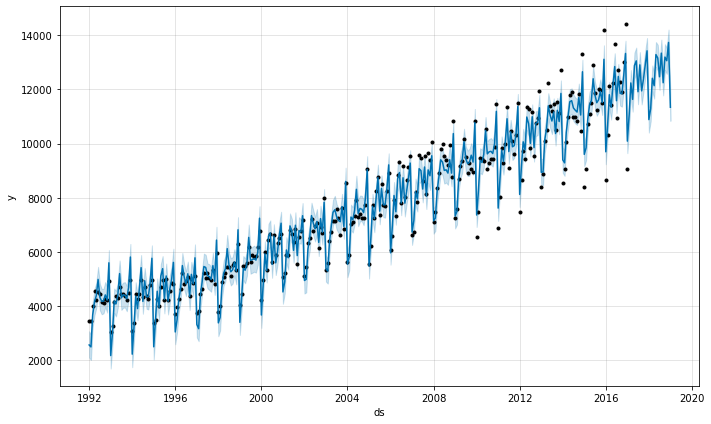

In [27]:
## Plotting the full model
fig1 = prop_mdl.plot(prop_forecast)

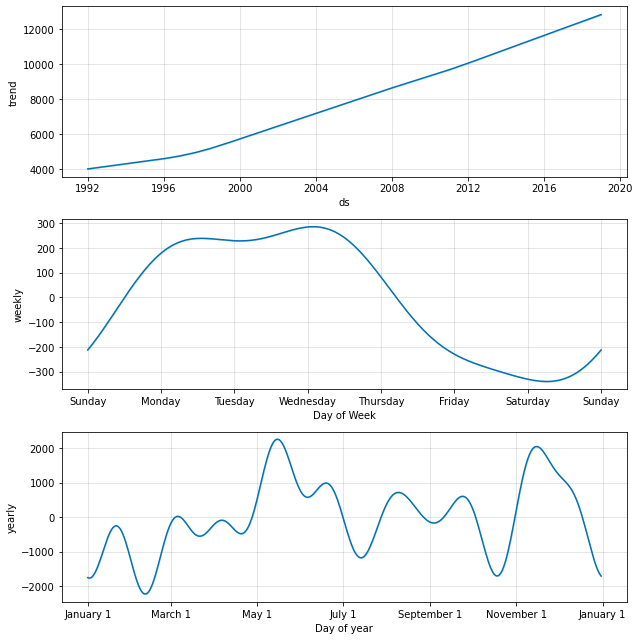

In [29]:
# plotting the components of the full prophet model
fig2 = prop_mdl.plot_components(prop_forecast)

In [30]:
prop_forecast[['ds','yhat']]
prop_forecast.loc[:,'yhat'][0:301]=np.nan
prop_forecast[['ds','yhat']]

,ds,yhat
0,1992-01-01,NaN
1,1992-02-01,NaN
2,1992-03-01,NaN
3,1992-04-01,NaN
4,1992-05-01,NaN
...,...,...
320,2018-09-01,12241.805532
321,2018-10-01,13187.757804
322,2018-11-01,13053.464365
323,2018-12-01,13728.125466


In [31]:
prop_res_df = pd.merge(alcohol,prop_forecast[['ds','yhat']],left_on='ds',right_on='ds',how='left')
prop_res_df.columns=['ds', 'y', 'forecast']

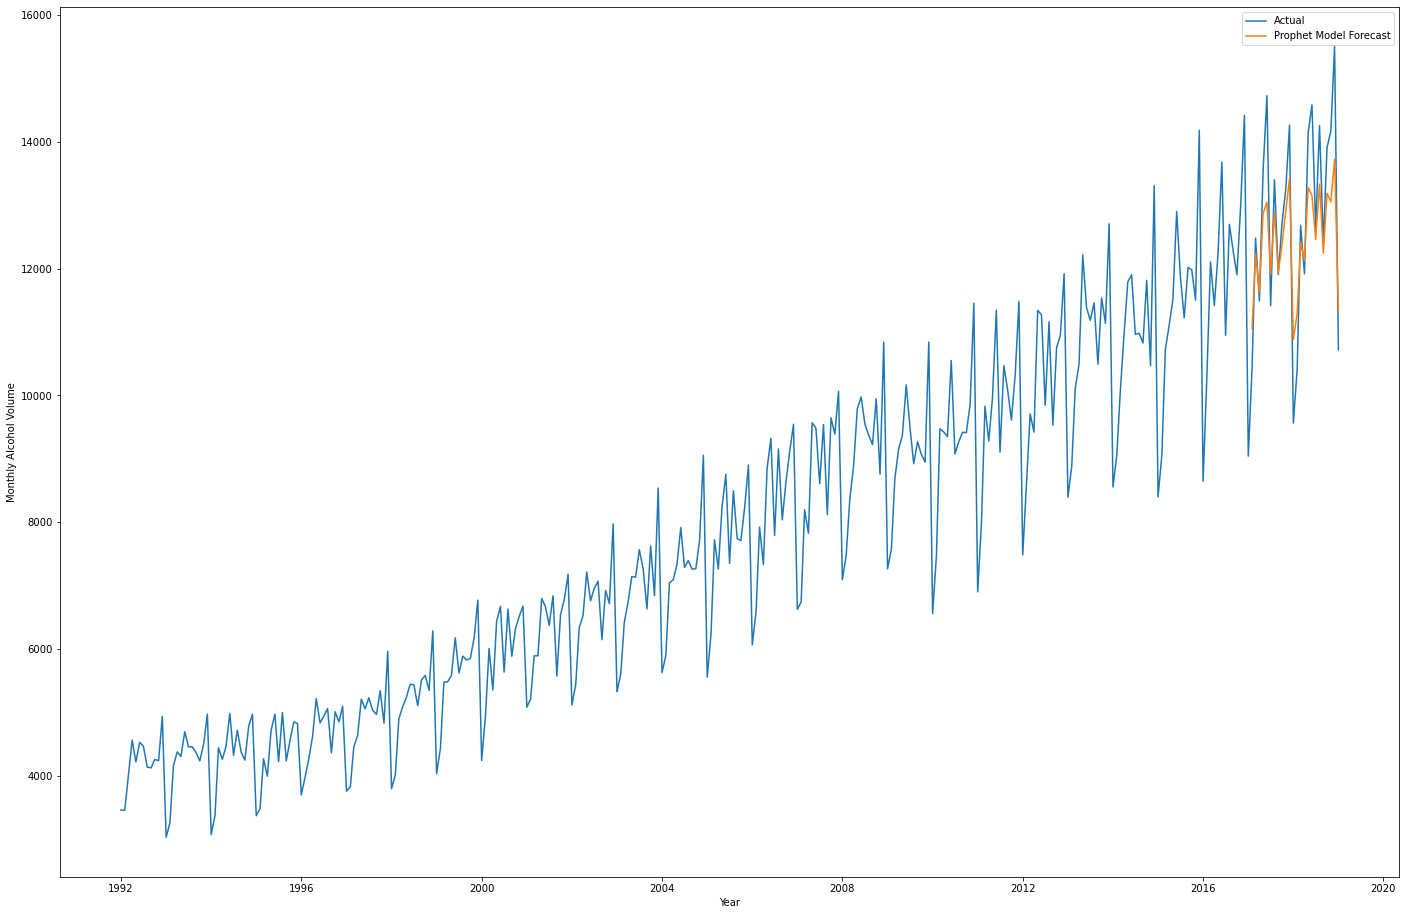

In [32]:
## Plotting Actuals alongside the test forecast values

plt.plot(prop_res_df['ds'],prop_res_df['y'],label='Actual')
plt.plot(prop_res_df['ds'],prop_res_df['forecast'],label='Prophet Model Forecast')
plt.ylabel('Monthly Alcohol Volume')
plt.xlabel('Year')
plt.legend()
plt.show()

In [33]:
smape_prophet = smape(prop_res_df['y'][-24:],prop_res_df['forecast'][-24:])
print(smape_prophet)

0.05333680102672348


## ThymeBoost gradient boosted tree model for Time Series

In [34]:
## Parameterizing, instantiating, and fitting a fairly vanilla Thymeboost model

train_alc
fcat_len = len(test_alc)


tb_model = tb.ThymeBoost(verbose=1,
    n_split_proposals=10,
    approximate_splits=True,
    exclude_splits=None,
    given_splits=None,
    cost_penalty=0.001,
    normalize_seasonality=True,
    regularization=1.2,
    n_rounds=None,
    smoothed_trend=False,
    scale_type=None,
    split_strategy='gradient',
    error_handle='raise')

fitted_mdl = tb_model.autofit(train_alc['y'],
                               seasonal_period=12)
predicted_output = tb_model.predict(fitted_mdl, fcat_len)
predicted_output

 36%|███████████████▏                          | 13/36 [00:00<00:00, 115.29it/s]

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.13082330542011256
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014725159299111208
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.13082330542011256
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014725159299111208
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -606.1249282574217
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1259.2276536234651
Boosting Terminated 
Using round

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 88.34it/s]



Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -606.1249282574217
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1259.2276536234651
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1261.6448382085669
Boosting Terminated 
Using round 3
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -606.1249282574217
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1259.2276536234651
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1261.6448382085669
Boosting Terminated 
Using round 3
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model

  0%|                                                    | 0/36 [00:00<?, ?it/s]

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.13002290191638965
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014771194049569591
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.13002290191638965
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014771194049569591
Boosting Terminated 
Using round 2
********** Round 1 **********

 39%|████████████████▎                         | 14/36 [00:00<00:00, 139.52it/s]


Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -605.9197997720185
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1254.0792366440905
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -605.9197997720185
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1254.0792366440905
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
fourier(10, True)
cost: 0.11655335701973062
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.002967646562497121
********** Round 3 **********
Using Split: None
Fi

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.13002290191638965
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014771194049569591
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: 0.014643017047869378
********** Round 4 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014596472643602702
Boosting Terminated 
Using round 4


 78%|█████████████████████████████████▍         | 28/36 [00:00<00:00, 90.53it/s]

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -605.9197997720185
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1254.0792366440905
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1256.6764158210285
Boosting Terminated 
Using round 3
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -605.9197997720185
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1254.0792366440905
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1256.6764158210285
Boosting Terminated 
Using round 3
********** Round 1 **********
Using Split: None
Fitting initial tr

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 86.35it/s]


Boosting Terminated 
Using round 3


  0%|                                                    | 0/36 [00:00<?, ?it/s]

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.12954662220918473
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014811220113021956
Boosting Terminated 
Using round 2
********** Round 1 **********

 39%|████████████████▎                         | 14/36 [00:00<00:00, 125.24it/s]


Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.12954662220918473
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014811220113021956
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -604.9696310133832
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1249.0604107764677
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -604.9696310133832
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1249.0604107764677
Boosting Terminated 
Using round 2
********** Round 1 *********

********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: 0.014690633272958697
********** Round 4 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.01464476320242887
Boosting Terminated 
Using round 4
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.12954662220918473
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.014811220113021956
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: 0.014690633272958697


 75%|████████████████████████████████▎          | 27/36 [00:00<00:00, 68.90it/s]

********** Round 4 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 0.01464476320242887
Boosting Terminated 
Using round 4
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -604.9696310133832
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1249.0604107764677
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1251.4883593180914
Boosting Terminated 
Using round 3
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: -604.9696310133832
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: -1249.0604107764677
********** Round 3 **********
Using Split: None
Fittin

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 68.58it/s]

Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
fourier(10, True)
cost: -604.4105809812239
********** Round 2 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1672.0664130475875
********** Round 3 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
fourier(10, True)
cost: -1786.0154368250692
********** Round 4 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: -1819.007770956638
Boosting Terminated 
Using round 4
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 0.12954662220918473
********** Round 2 **********
Using Split: None
Fitting global with trend model:
ses()
seasonal model:
None
cost: 0.01621398013660954
********** Round 3 **********
Using Split: None
Fitting global w

,predictions,predicted_trend,predicted_seasonality,predicted_exogenous,predicted_upper,predicted_lower
301,10191.068360,12105.147005,0.841879,1.0,13576.018324,6806.118396
302,12022.369043,12152.477481,0.989294,1.0,15442.522878,8602.215208
303,12017.740355,12199.993017,0.985061,1.0,15473.098061,8562.382649
304,12969.131563,12247.694335,1.058904,1.0,16459.693140,9478.569987
305,13731.578918,12295.582164,1.116790,1.0,17257.344366,10205.813471
306,12418.632566,12343.657231,1.006074,1.0,15979.601884,8857.663248
307,12994.056957,12391.920269,1.048591,1.0,16590.230145,9397.883768
308,12465.813388,12440.372013,1.002045,1.0,16097.190448,8834.436329
309,12924.133941,12489.013201,1.034840,1.0,16590.714872,9257.553011
310,13059.138457,12537.844573,1.041578,1.0,16760.923258,9357.353655


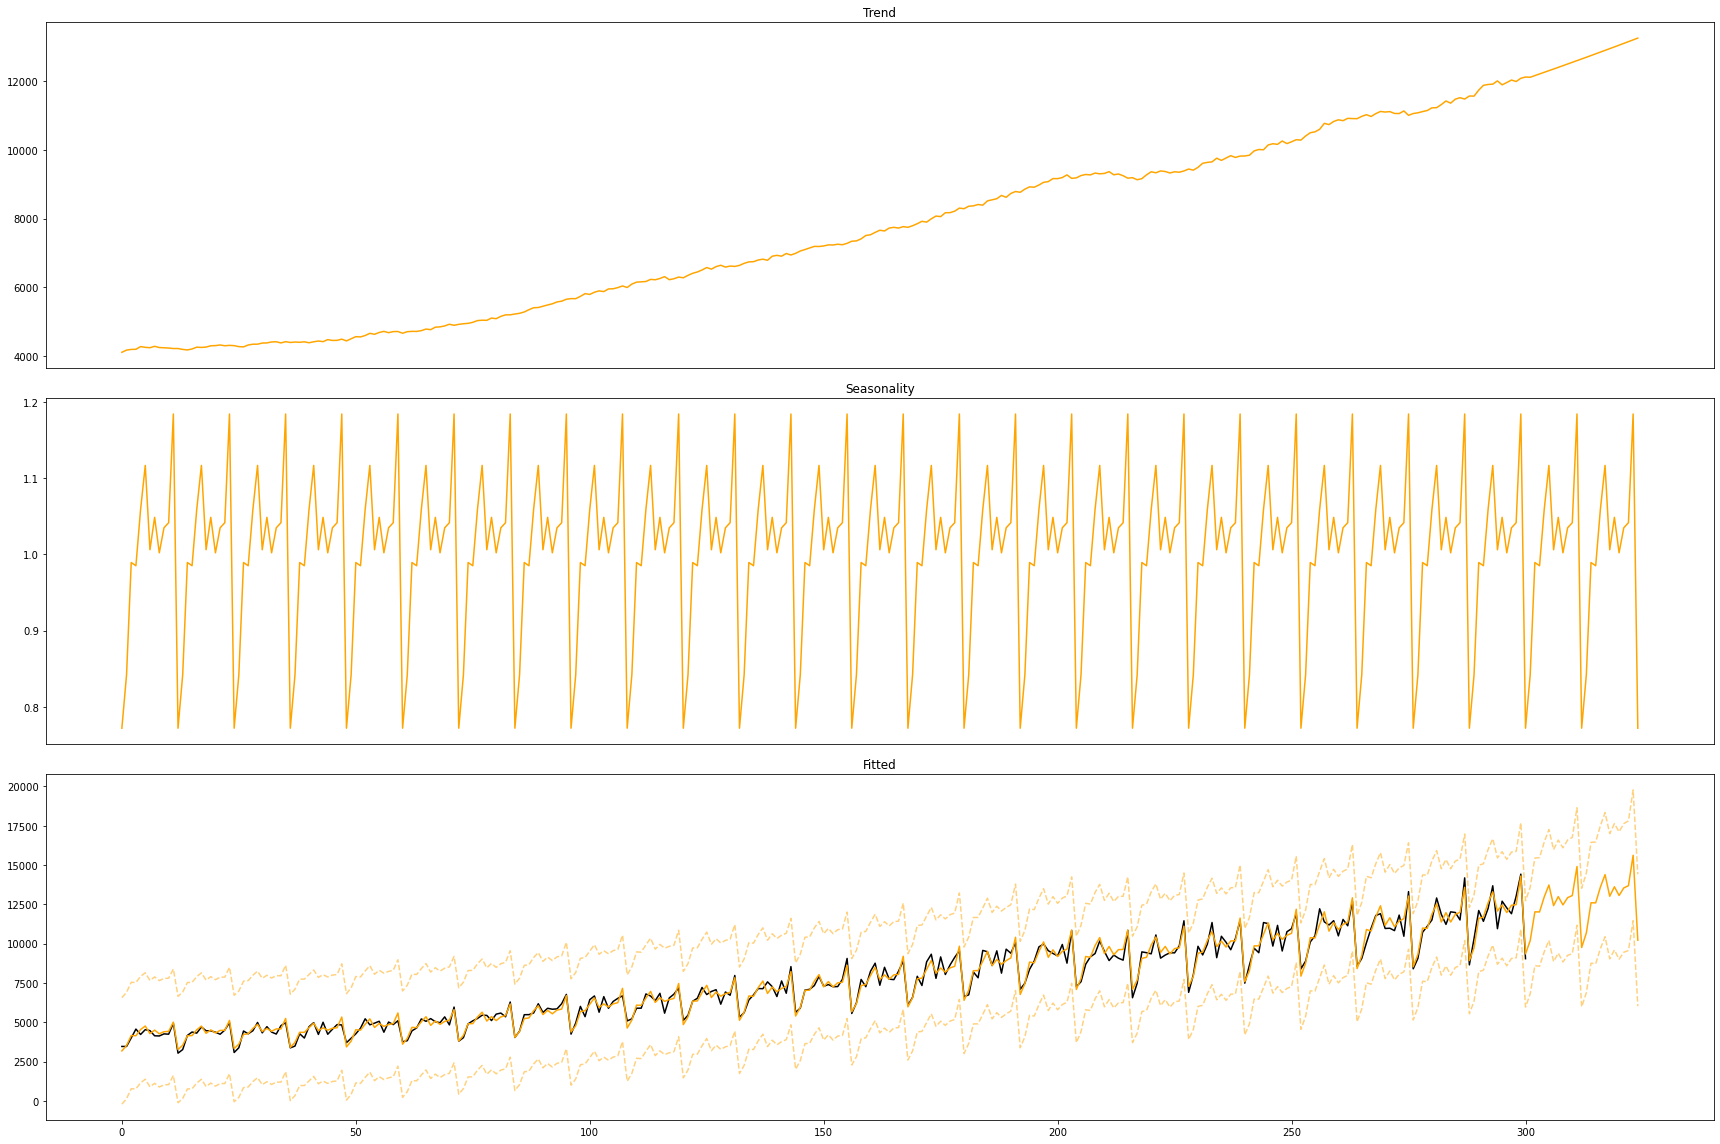

In [35]:
## Plotting the Thymeboost model & components
predicted_output
tb_model.plot_components(fitted_mdl, predicted_output)

In [36]:
## Smape for the Thymeboost tree model is 0.035904372773051425


FF = predicted_output['predictions']
AA = test_alc['y']
smape_thymeboost = smape(AA,FF)
smape_thymeboost

0.035904372773051425

In [37]:
## Sarima model performed the best, of the four models I tested in this notebook
print('SMAPE of ETS Model:',smape_ETS)
print('SMAPE of Sarima Model:',smape_arima)
print('SMAPE of Prophet Model:',smape_prophet)
print('SMAPE of ThymeBoost Model:',smape_thymeboost)

SMAPE of ETS Model: 0.11856981444448468
SMAPE of Sarima Model: 0.02540259312823353
SMAPE of Prophet Model: 0.05333680102672348
SMAPE of ThymeBoost Model: 0.035904372773051425
